# CM6-ICO-VHR

conda env: new `phd_v3` (in `envs/phd`)

https://forge.ipsl.jussieu.fr/igcmg/wiki/IPSLCM6/IPSL-CM6A-ATM-ICO#IPSL-CM6A-ATM-ICO

## CM6-ICO-HR
- CICLAD: `/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6`

## CM6-ICO-VHR
- CICLAD: `/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6`

## Import modules

In [4]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Define paths

In [5]:
root = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/'
exp_ref = 'CM6-ICO-HR'
exp_new = 'CM6-ICO-VHR'

In [6]:
# !ls /thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/LMDZOR-STD-REF/ATM/Analyse/TS_MO/

## Make function to get data

In [7]:
def get_data(list_vars, period, season, zone):
    """
        Get reference and new experiments + observations.

        Parameters
        ----------
        list_vars : list
            List of variables. Options are: 'frac_snow', 't2m', 'precip', 'ta'
        period : slice
            Period
        season : str
            Season (ex: 'annual', 'DJF', '1')
        zone : str
            Zone of study (ex: 'HMA', 'GLOB', 'NH')

        Returns
        -------
        ref, new, obs : list of Dataset
            List of reference and new experiments + observations regrided on model dataset (not 
            loaded) for each variable.
            
        clim_ref, clim_new, clim_obs : list of DataArray
            List of reference and new experiments + observations regrided on model climatologies
            for each variable.

        Example
        -------
        >>>  list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
                ['frac_snow', 't2m', 'precip'], slice('1981','1989'), 'annual', 'GLOB'
            )

    """
    
    list_ref = []
    list_new = []
    list_obs = []
    list_clim_ref = []
    list_clim_new = []
    list_clim_obs = []
       
    list_var_SRF = ['frac_snow', 'snc']
    list_var_ATM = ['t2m', 'tas', 'precip', 'pr', 'ta']
    latlim, lonlim = u.get_zone(zone)

    for var in list_vars:

        print(
            f"""
    #############
    ### Variable: {var} 
    #############
            """
        )

        if var in list_var_SRF:
            component = 'SRF'
            table = 'LImon'
        elif var in list_var_ATM:
            component = 'ATM'
            table = 'Amon'
        else:
            raise ValueError(f"Invalid var argument: '{var}'. Valid names are: 'frac_snow'.")

        path = root+exp_ref+'.sponge.run.01/CMIP6/'+component+'/'+var+'_'+table+'_*gr*.nc'
        print('Open reference simulation:\n'+path+'\n')
        ref = xr.open_mfdataset(path)[var]
        ref.attrs['title'] = exp_ref

        path = root+exp_new+'.sponge.run.01/CMIP6/'+component+'/'+var+'_'+table+'_*gr*.nc'
        print('Open new simulation:\n'+path+'\n')
        new = xr.open_mfdataset(path)[var]
        
        regridder = xe.Regridder(new, ref, 'bilinear', periodic=False, reuse_weights=True)
        new = regridder(new)
        
        new.attrs['title'] = exp_new
        
        

        # Rename time dimension and sort latitude from -90 to 90
#         ref = ref.rename({'time_counter': 'time'}).sortby('lat')
#         new = new.rename({'time_counter': 'time'}).sortby('lat')

        # Compute climatolgy
        clim_ref = u.clim(
            ref.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        clim_ref.attrs['season'] = season
        clim_ref.attrs['zone'] = zone

        clim_new = u.clim(
            new.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        clim_new.attrs['season'] = season
        clim_new.attrs['zone'] = zone

        # Unit conversion
        if var in ['tas', 'tmp', 't2m', 'ta']:
            with xr.set_options(keep_attrs=True):
                clim_ref -= 273.15
                clim_new -= 273.15
            clim_ref.attrs['units'] = '°C'
            clim_new.attrs['units'] = '°C'

            if var in ['ta']:
                clim_ref = clim_ref.assign_coords({'plev': clim_ref.plev/100}).rename({'plev': 'level'})
                clim_new = clim_new .assign_coords({'plev': clim_new.plev/100}).rename({'plev': 'level'})

        elif var in ['pr', 'precip']:
            with xr.set_options(keep_attrs=True):
                clim_ref *= 86400
                clim_new *= 86400
            clim_ref.attrs['units'] = 'mm/day'
            clim_new.attrs['units'] = 'mm/day'

        # Get observations
        if var in ['snc', 'frac_snow']:
            obs_name = 'NH_SCE_CDR'
            version = 'v01r01'
        elif var in ['tas', 'tmp', 't2m']:
            obs_name = 'CRU_TS'
            version = '4.04'
        elif var in ['pr', 'precip']:
            obs_name = 'APHRO_MA'
            version = 'V1101'
        elif var in ['ta']:
            obs_name = 'ERAI'
            version = ''

        obs = u.get_obs(obs_name, version, var, period=period, machine='CICLAD', regrid=clim_ref)
        clim_obs = u.clim(
            obs.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        
        list_ref.append(ref)
        list_new.append(new)
        list_obs.append(obs)
        list_clim_ref.append(clim_ref)
        list_clim_new.append(clim_new)
        list_clim_obs.append(clim_obs)
               
    return list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs

## Plot differences and compare to observation

### HMA

#### Get data

In [8]:
list_vars = ['snc', 'tas', 'pr']
# list_vars = ['frac_snow', 'tas', 'precip']

# Period for climatologies (removing first year spin-up)
period = slice('1982','2013')
season = 'annual'
zone = 'HMA'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: snc 
    #############
            
Open reference simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc

Open new simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc

Create weight file: bilinear_720x1440_360x720.nc
Get observation: NH_SCE_CDR
/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc



/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Create weight file: bilinear_88x88_60x101.nc

    #############
    ### Variable: tas 
    #############
            
Open reference simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/ATM/tas_Amon_*gr*.nc

Open new simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/ATM/tas_Amon_*gr*.nc

Reuse existing file: bilinear_720x1440_360x720.nc
Get observation: CRU_TS
/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc

Create weight file: bilinear_360x720_60x101_peri.nc

    #############
    ### Variable: pr 
    #############
            
Open reference simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/ATM/pr_Amon_*gr*.nc

Open new simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/ATM/pr_Amon_*gr*.nc

Reuse existing file: bilinear_720x1440_360x720.nc
Get observation: APHRO_MA


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Create weight file: bilinear_140x180_60x101.nc


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### Make plots

/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


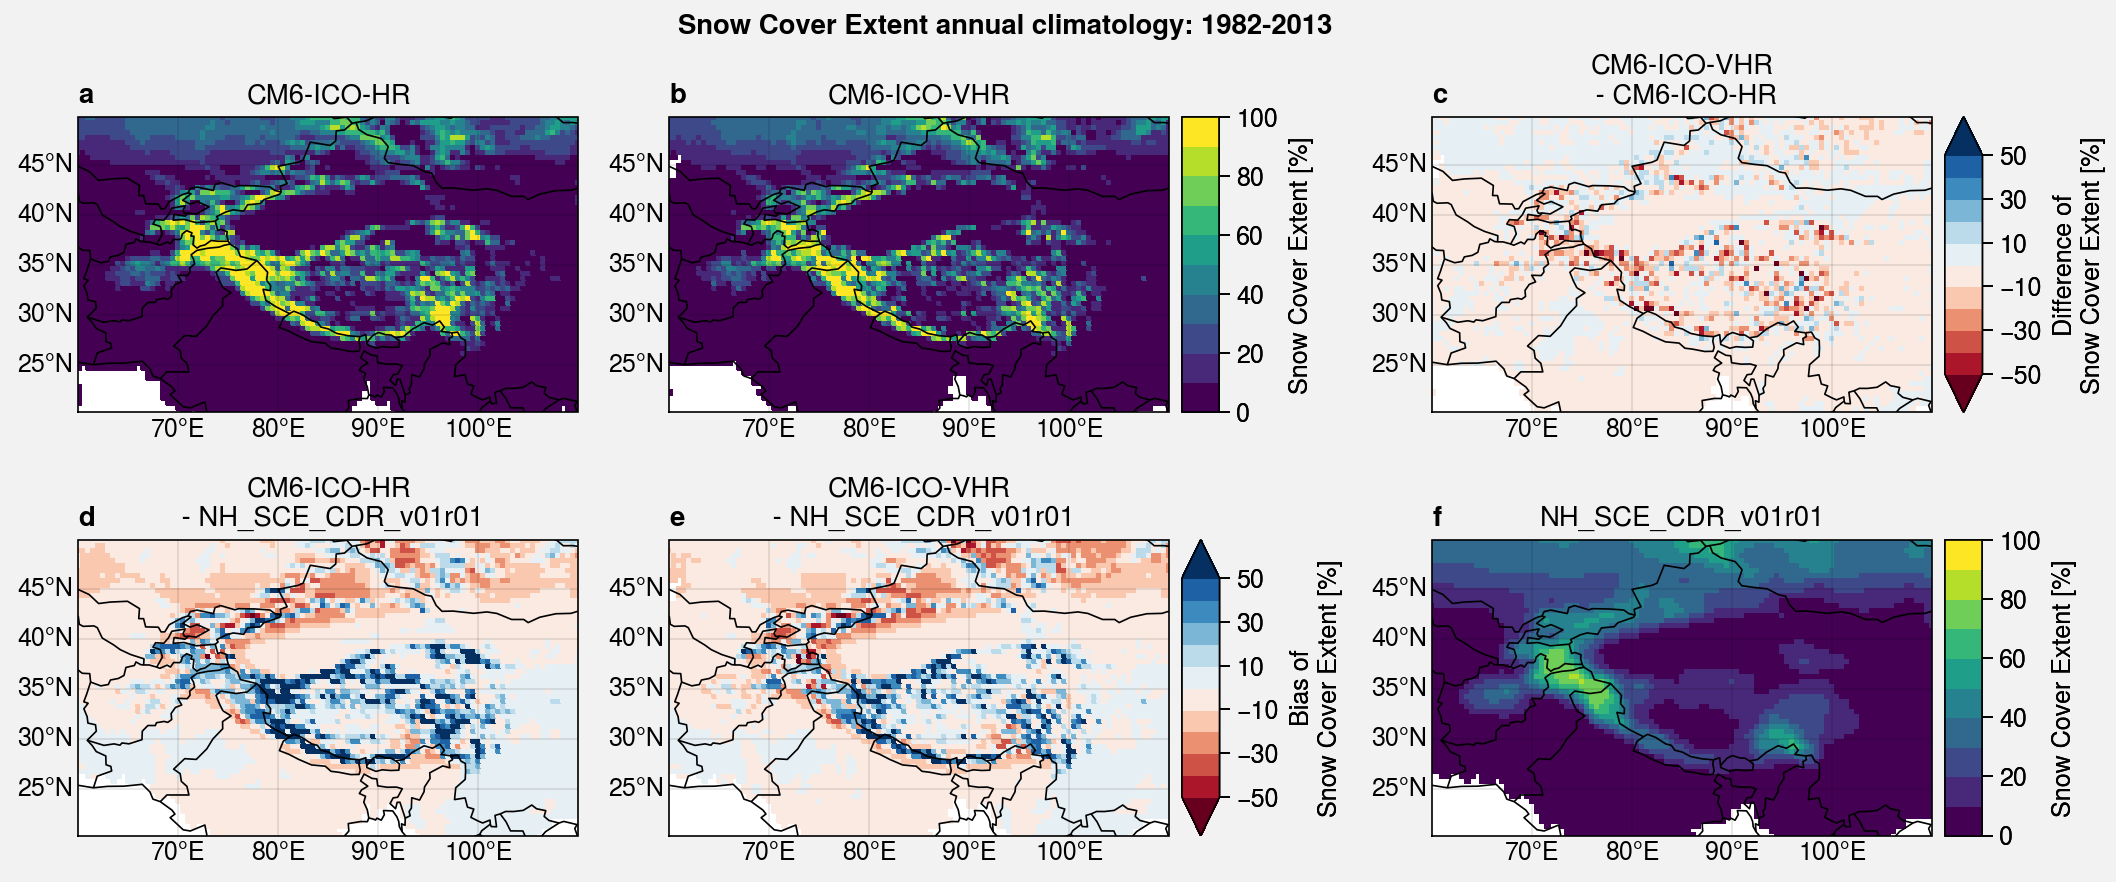

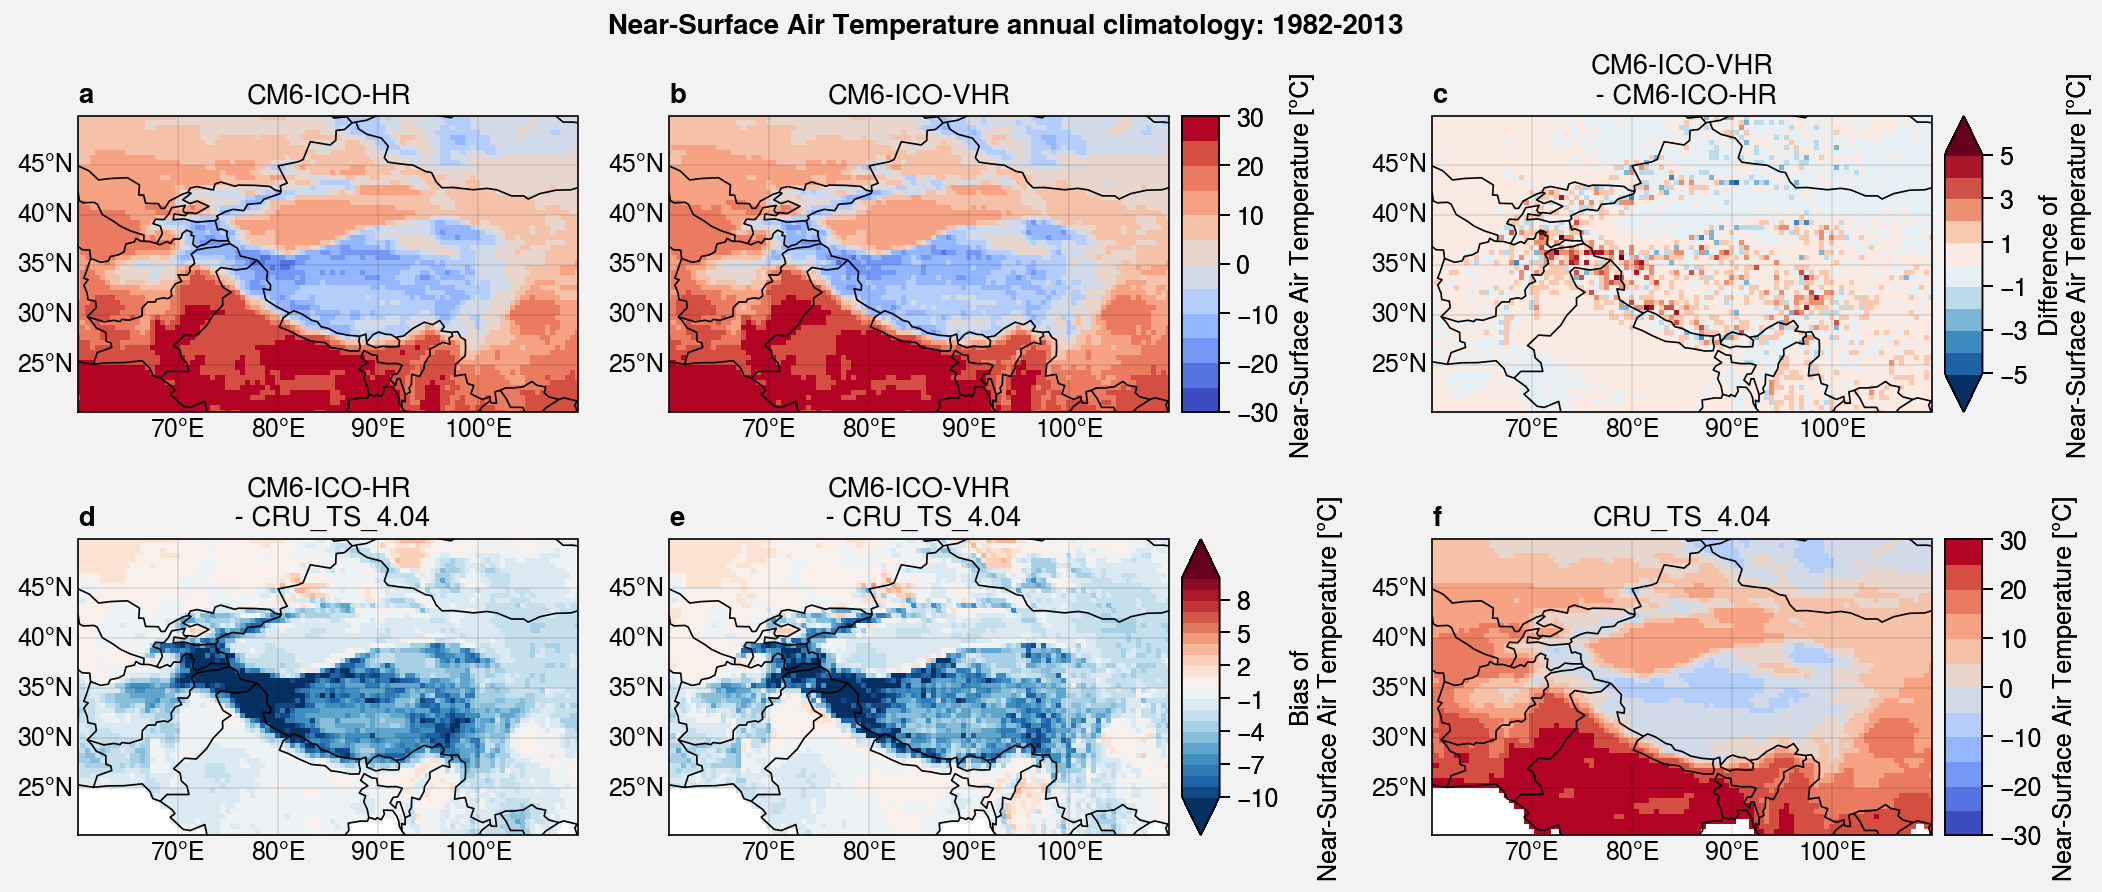

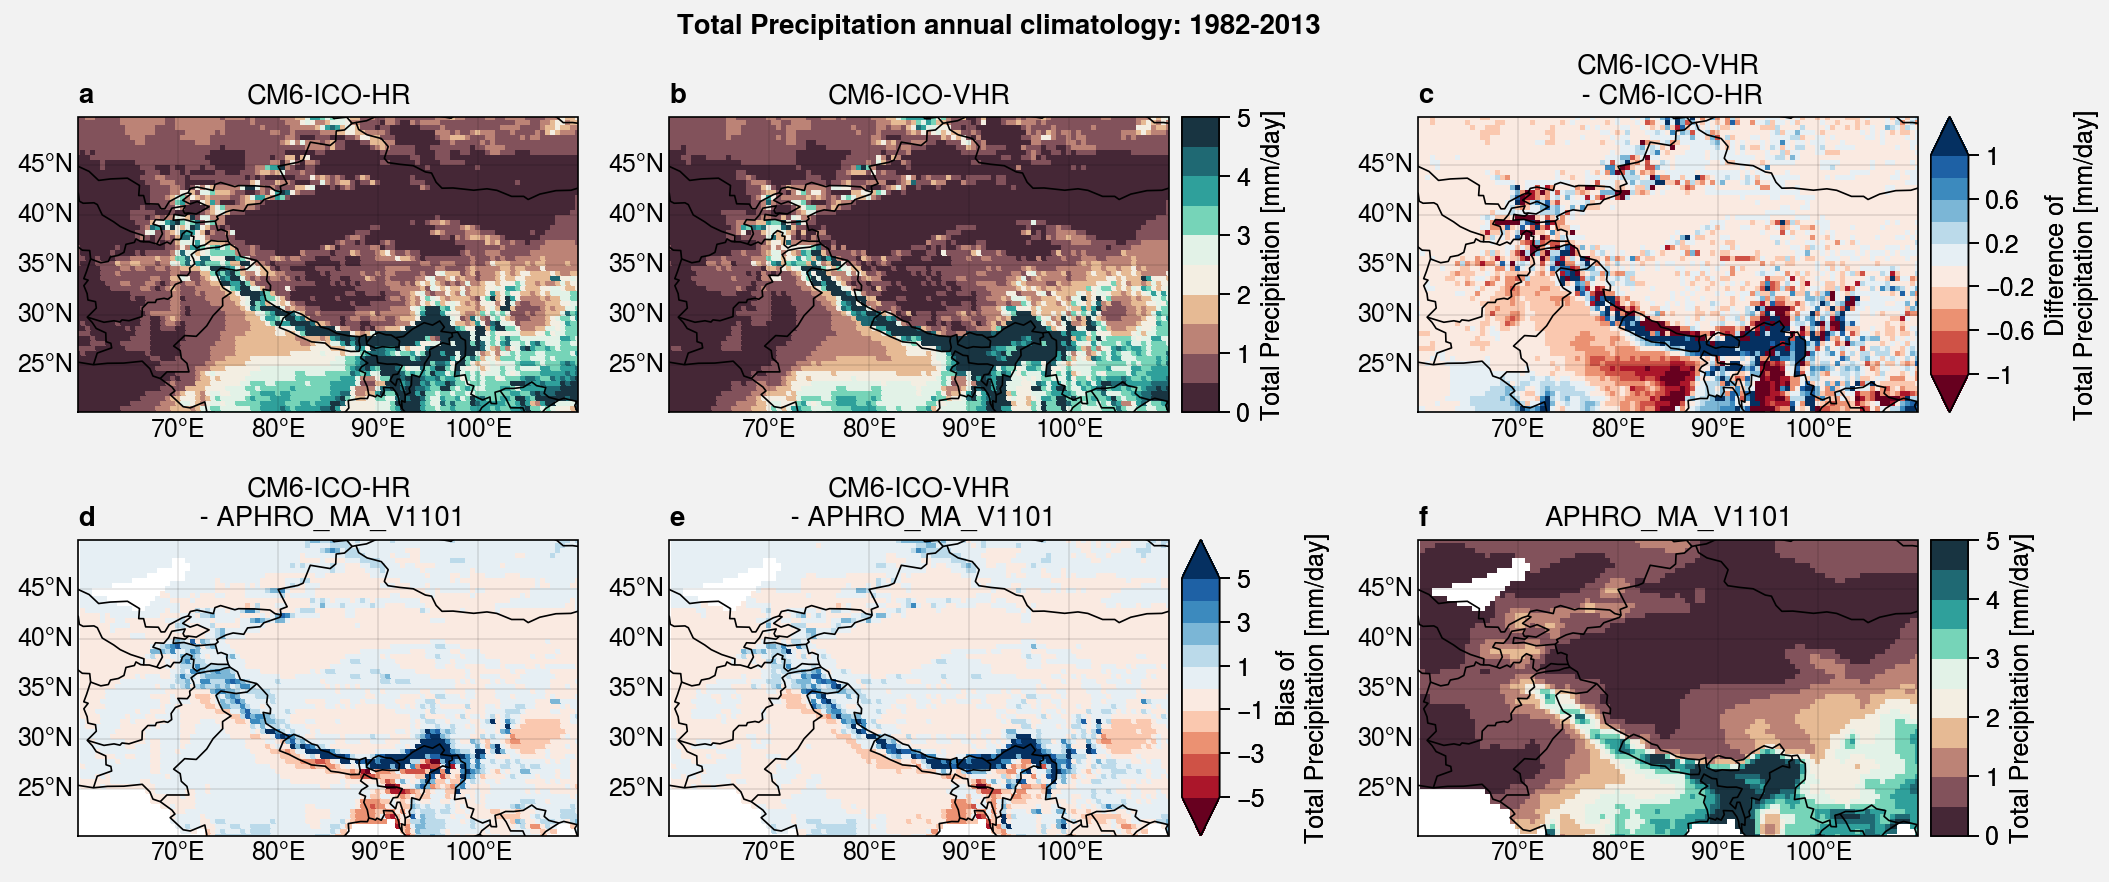

In [9]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

### Northern Hemisphere

#### Get data

In [10]:
list_vars = ['snc', 'tas']
# list_vars = ['frac_snow', 'tas', 'precip']

# Period for climatologies (removing first year spin-up)
period = slice('1982','2013')
season = 'annual'
zone = 'NH'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: snc 
    #############
            
Open reference simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc

Open new simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc

Reuse existing file: bilinear_720x1440_360x720.nc
Get observation: NH_SCE_CDR
/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc



/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Create weight file: bilinear_88x88_180x720.nc


/home/mlalande/.conda/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



    #############
    ### Variable: tas 
    #############
            
Open reference simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/ATM/tas_Amon_*gr*.nc

Open new simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/ATM/tas_Amon_*gr*.nc

Reuse existing file: bilinear_720x1440_360x720.nc
Get observation: CRU_TS
/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc

Create weight file: bilinear_360x720_180x720_peri.nc


#### Make plots

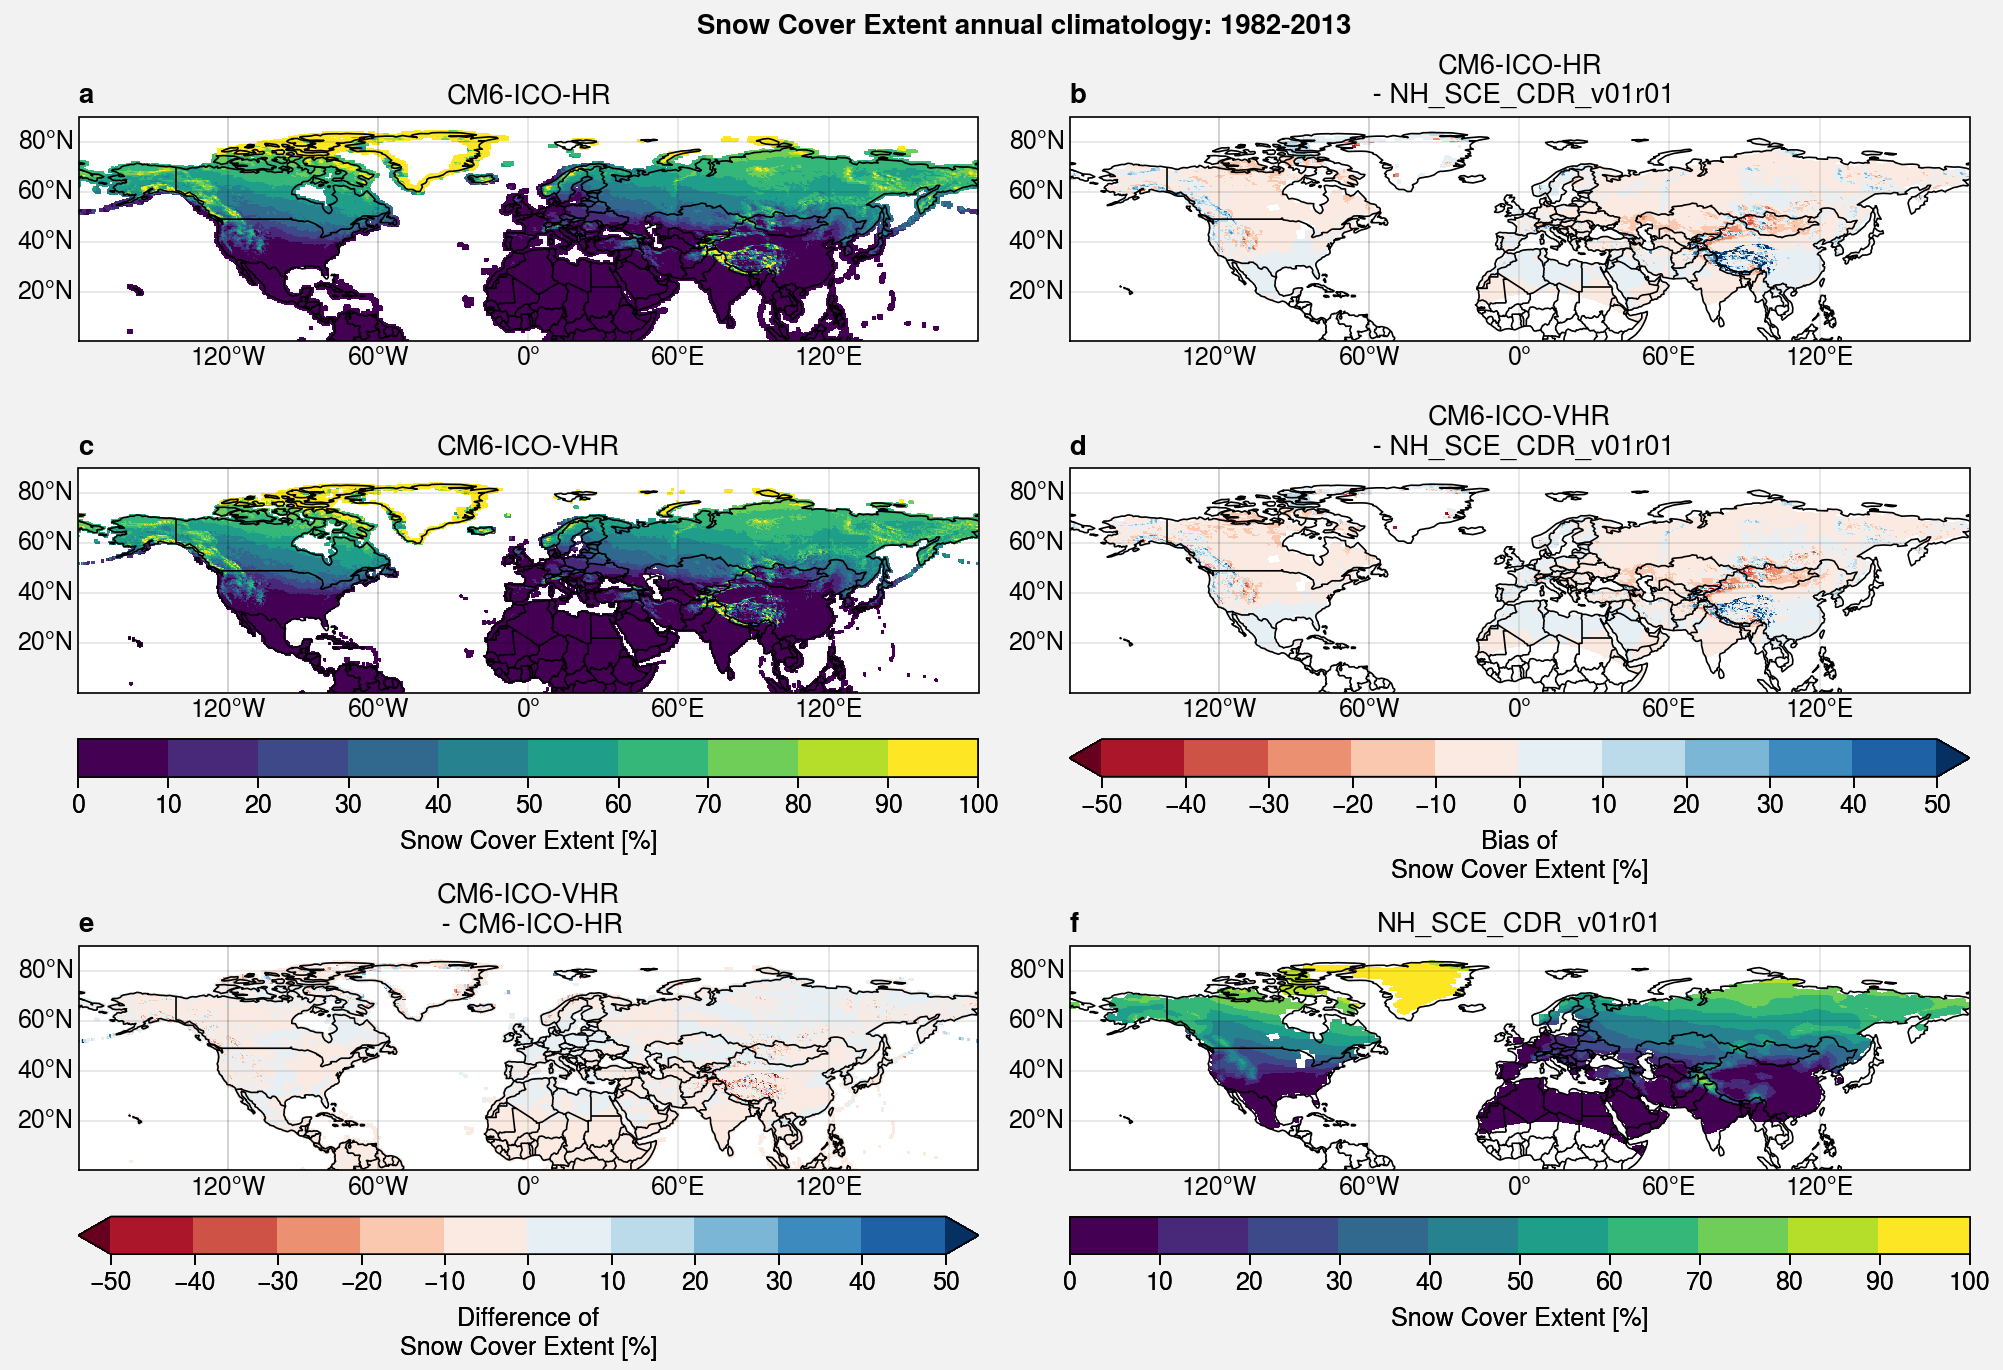

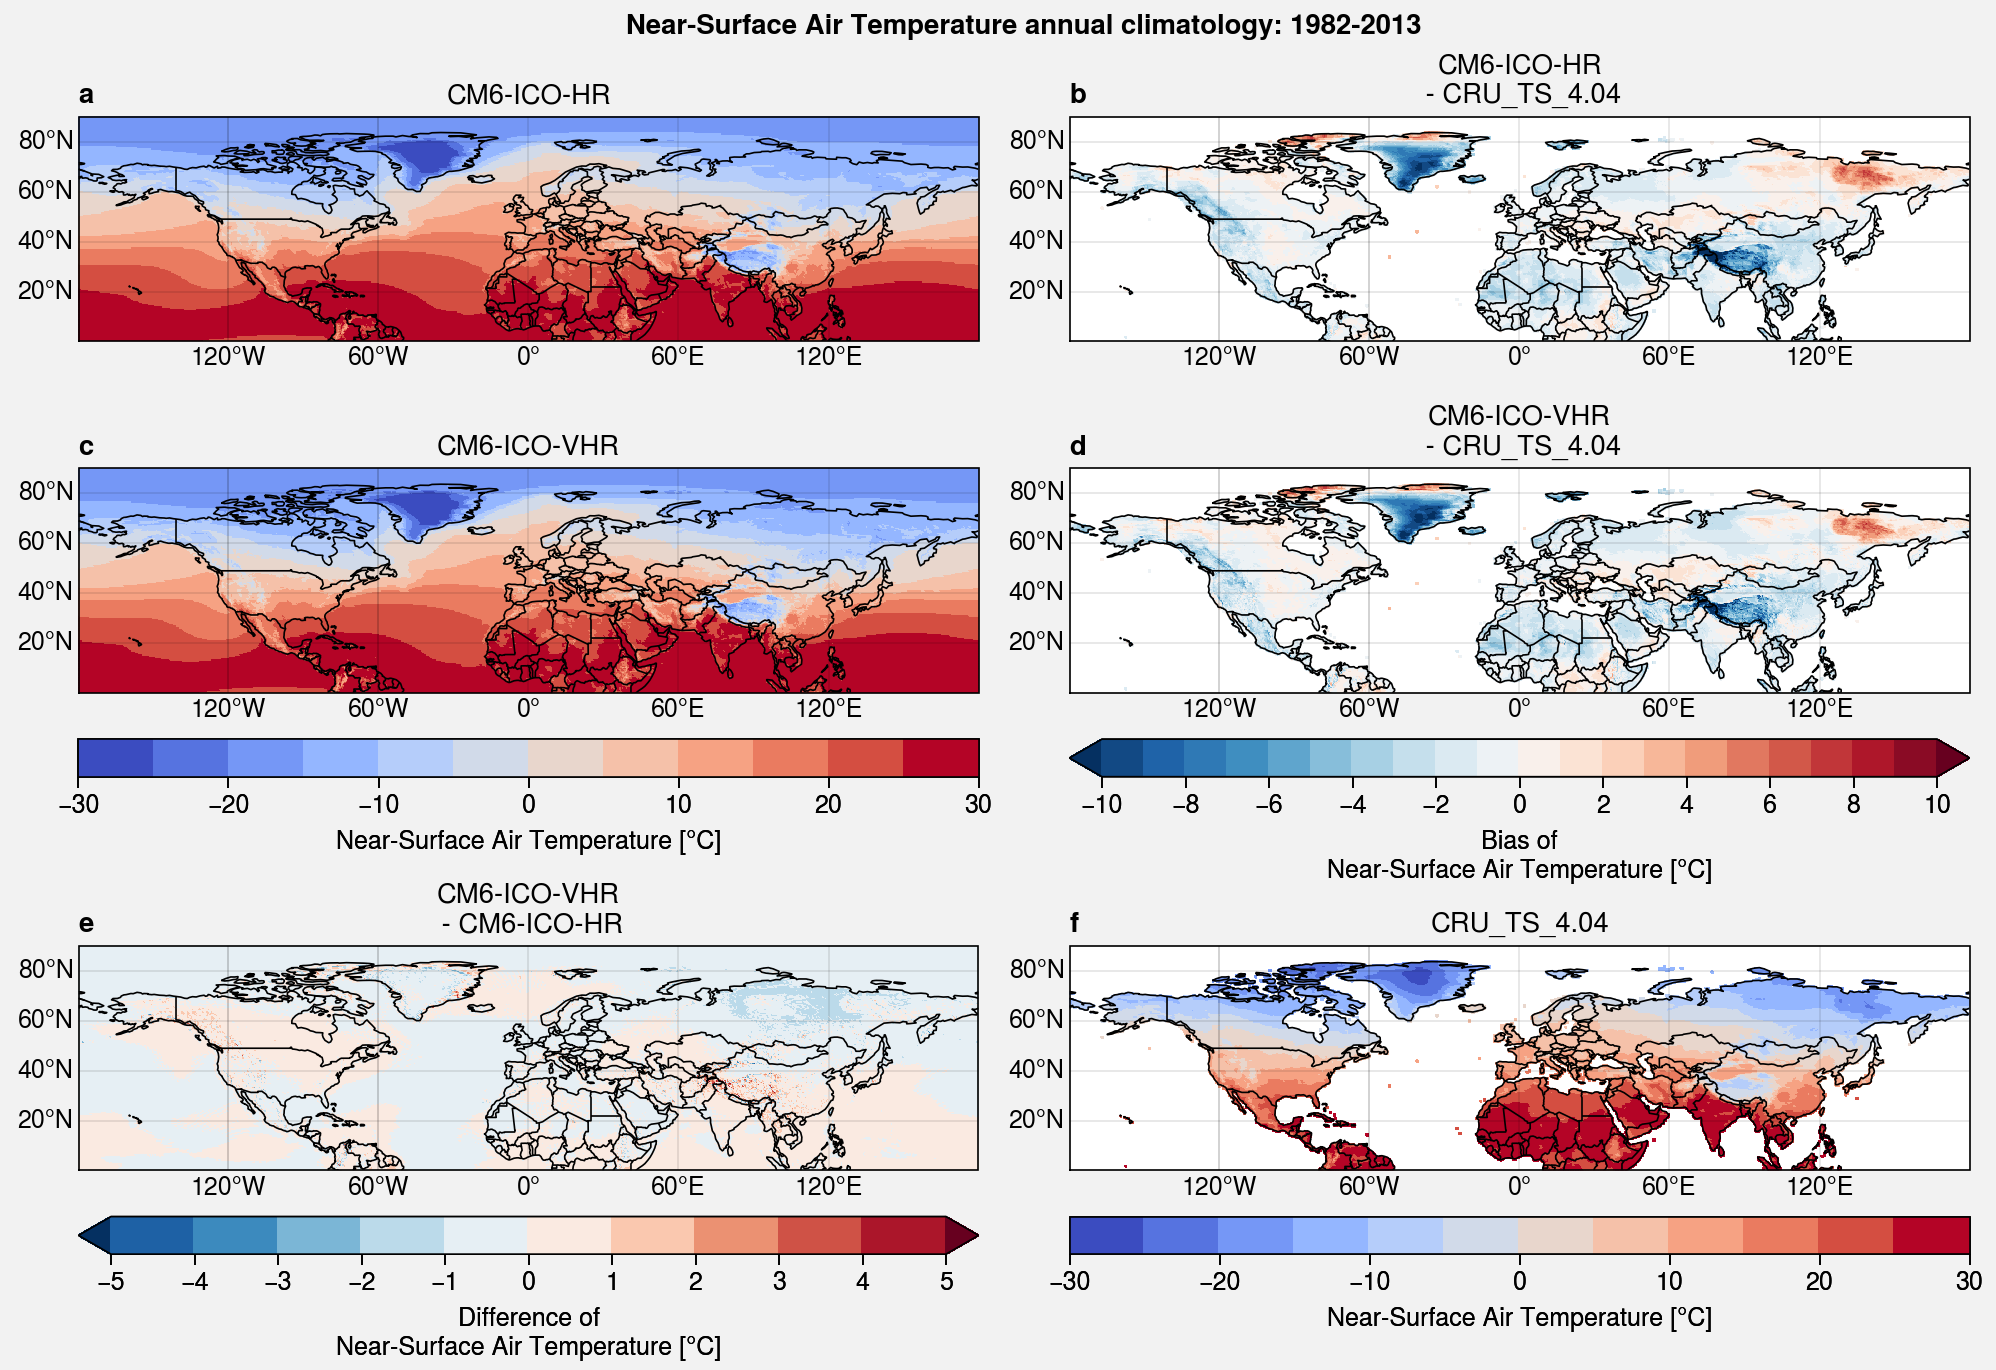

In [11]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

## Zonal plots

### Global

#### Get data

In [12]:
list_vars = ['ta']

# Period for climatologies (removing first year spin-up)
period = slice('1982','2013')
season = 'annual'
zone = 'GLOB'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: ta 
    #############
            
Open reference simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/ATM/ta_Amon_*gr*.nc

Open new simulation:
/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/ATM/ta_Amon_*gr*.nc

Reuse existing file: bilinear_720x1440_360x720.nc
Get observation: ERAI
/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc

Create weight file: bilinear_241x480_360x720_peri.nc


#### Make plots

In [ ]:
for i in range(len(list_vars)):
    list_clim_ref[i].load()
    list_clim_new[i].load()
    list_clim_obs[i].load()

In [ ]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_zonal_bias_HMA(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )